# Concept Bottleneck Model

### Import libaries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize, Normalize
import os
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import numpy as np


### Import dataset

In [3]:
root_dir = f'{os.getcwd()}/CUB_200_2011/images/'

transform = transforms.Compose([
    Resize((299, 299)),  # Resize images to a fixed size, for example, 224x224
    ToTensor()           # Convert images to tensors
])
dataset = ImageFolder(root=root_dir,transform=transform)


In [4]:
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Split the dataset randomly into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print the sizes of the splits
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 9430
Validation set size: 1178
Test set size: 1180


### Show images

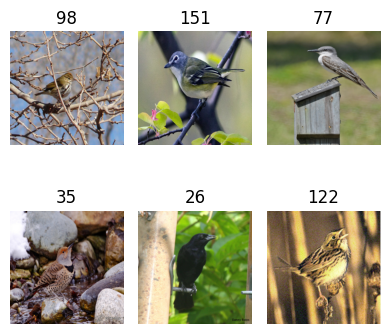

In [5]:
def show_images(dataset, num_images=5):
    # Get random samples from the dataset
    random_indices = torch.randperm(len(dataset))[:num_images]
    plt.figure(figsize=(4,4))
    # Iterate over the random indices and display images
    for index, idx in enumerate(random_indices):
        image, _ = dataset[idx]
  # Convert PIL image to tensor
        plt.subplot(2, 3, index + 1)
        plt.imshow(image.permute(1,2,0))  # Convert tensor to ndarray and display
        plt.axis('off')
        plt.title(_)
    plt.tight_layout()
    plt.show()
    
# Call the function to display images
show_images(dataset, num_images=6)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


### Data extraction function (from paper repository)

In [26]:
import os
import random
import pickle
import argparse
from os import listdir
from os.path import isfile, isdir, join
from collections import defaultdict as ddict


def extract_data(data_dir):
    cwd = os.getcwd()
    data_path = join(cwd, data_dir + "/images")
    val_ratio = 0.1

    path_to_id_map = dict()  # map from full image path to image id
    with open(data_path.replace("images", "images.txt"), "r") as f:
        for line in f:
            items = line.strip().split()
            path_to_id_map[join(data_path, items[1])] = int(items[0])

    attribute_labels_all = ddict(
        list
    )  # map from image id to a list of attribute labels
    attribute_certainties_all = ddict(
        list
    )  # map from image id to a list of attribute certainties
    attribute_uncertain_labels_all = ddict(
        list
    )  # map from image id to a list of attribute labels calibrated for uncertainty
    # 1 = not visible, 2 = guessing, 3 = probably, 4 = definitely
    uncertainty_map = {
        1: {
            1: 0,
            2: 0.5,
            3: 0.75,
            4: 1,
        },  # calibrate main label based on uncertainty label
        0: {1: 0, 2: 0.5, 3: 0.25, 4: 0},
    }
    with open(join(cwd, data_dir + "/attributes/image_attribute_labels.txt"), "r") as f:
        for line in f:
            file_idx, attribute_idx, attribute_label, attribute_certainty = (
                line.strip().split()[:4]
            )
            attribute_label = int(attribute_label)
            attribute_certainty = int(attribute_certainty)
            uncertain_label = uncertainty_map[attribute_label][attribute_certainty]
            attribute_labels_all[int(file_idx)].append(attribute_label)
            attribute_uncertain_labels_all[int(file_idx)].append(uncertain_label)
            attribute_certainties_all[int(file_idx)].append(attribute_certainty)

    is_train_test = dict()  # map from image id to 0 / 1 (1 = train)
    with open(join(cwd, data_dir + "/train_test_split.txt"), "r") as f:
        for line in f:
            idx, is_train = line.strip().split()
            is_train_test[int(idx)] = int(is_train)
    print(
        "Number of train images from official train test split:",
        sum(list(is_train_test.values())),
    )

    train_val_data, test_data = [], []
    train_data, val_data = [], []
    folder_list = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    folder_list.sort()  # sort by class index
    for i, folder in enumerate(folder_list[:2]):
        folder_path = join(data_path, folder)
        classfile_list = [
            cf
            for cf in listdir(folder_path)
            if (isfile(join(folder_path, cf)) and cf[0] != ".")
        ]
        # classfile_list.sort()
        for cf in classfile_list:
            img_id = path_to_id_map[join(folder_path, cf)]
            img_path = join(folder_path, cf)
            metadata = {
                "id": img_id,
                "img_path": img_path,
                "img": dataset[i],
                "class_label": i,
                "attribute_label": torch.tensor(attribute_labels_all[img_id],dtype=torch.float32),
                "attribute_certainty": attribute_certainties_all[img_id],
                "uncertain_attribute_label": attribute_uncertain_labels_all[img_id],
            }
            if is_train_test[img_id]:
                train_val_data.append(metadata)
                # if val_files is not None:
                #     if img_path in val_files:
                #         val_data.append(metadata)
                #     else:
                #         train_data.append(metadata)
            else:
                test_data.append(metadata)

    random.shuffle(train_val_data)
    split = int(val_ratio * len(train_val_data))
    train_data = train_val_data[split:]
    val_data = train_val_data[:split]
    print("Size of train set:", len(train_data))
    return train_data, val_data, test_data

In [27]:
data_dir = f'{os.getcwd()}/CUB_200_2011/'
train_dataset, val_dataset, test_dataset = extract_data(data_dir)
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=True)


Number of train images from official train test split: 5994
Size of train set: 54


### Import model

In [90]:
# Load pre-trained InceptionV3 model
model = models.inception_v3(weights=True)

num_attribute_labels = 312

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the top classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_attribute_labels)  # Adjust the number of output classes


### Train

In [30]:

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch['img'][0]
        labels = batch['attribute_label']
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 0.6163
Epoch 2/10, Loss: 0.3119
Epoch 3/10, Loss: 0.2164
Epoch 4/10, Loss: 0.1921
Epoch 5/10, Loss: 0.1852
Epoch 6/10, Loss: 0.1839
Epoch 7/10, Loss: 0.1802
Epoch 8/10, Loss: 0.1766
Epoch 9/10, Loss: 0.1749
Epoch 10/10, Loss: 0.1723


### Evaluation

In [84]:
# Accuracy functions

def accuracy(output, target, topk=(1,)):
    """
    Computes the precision@k for the specified values of k
    output and target are Torch tensors
    """
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    temp = target.view(1, -1).expand_as(pred)
    temp = temp.cuda()
    correct = pred.eq(temp)
    
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def binary_accuracy(output, target):
    """
    Computes the accuracy for multiple binary predictions
    output and target are Torch tensors
    """
    pred = output.cpu() >= 0.5
    #print(list(output.data.cpu().numpy()))
    #print(list(pred.data[0].numpy()))
    #print(list(target.data[0].numpy()))
    #print(pred.size(), target.size())
    acc = (pred.int()).eq(target.int()).sum()
    acc = acc*100 / np.prod(np.array(target.size()))
    return acc

In [ ]:
# Evaluate the model
model.eval()

total = 0
with torch.no_grad():
    accuracy = 0
    for batch in test_loader:
        inputs = batch['img'][0]
        labels = batch['attribute_label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        accuracy += binary_accuracy(outputs, labels)
        total+=1
    accuracy /= total
    print(accuracy)
    
